In [1]:
import time
from pennylane import numpy as np 

st = time.time()
np.random.seed(12345678)

# Technology Laboratory: Exploring Quantum Signal Processing and the Quantum Singular Value Transformation

**Jay Soni**  
Quantum Software Developer  
XanaduAI

**James D Whitfield**  
Amazon Visiting Academic  
Dartmouth College

Instructor: James Whitfield (james.d.whitfield@dartmouth.edu), Amazon Visiting Academic;

## Introduction 

The Quantum Singular Value Transformation (QSVT) algorithm$^{[1]}$ allows us to transform the singular values of a matrix **without** the need for explicit diagonalization. It's a very versatile framework that can be used to recover some of the most well-known algorithms in quantum computing (search, hamiltonian simulation, factoring)$^{[2]}$. In this laboratory we will explore the concept of Quantum Signal Processing (QSP) that underpins QSVT then, we will use this concept to build a polynomial function approximator. Finally, we will learn about qubitization and use it to generalize the QSP theorem to QSVT! 

Additionally, this lab will be using PennyLane to generate and execute quantum circuits. If you don't have PennyLane installed on your machine, please follow the installation instructions [here](https://pennylane.ai/install/).

## Outline
1. **Reflections, Rotations and ... Polynomials?**
    - A. Build Intuition
    - B. Quantum Signal Processing Theorem 
    - C. Code Example
2. **Its Fun Fitting Functions!**
    - A. Learning phase angles on the Fly 
    - B. QSP as a polynomial function approximator
    - C. Recovering the right Unitary 
3. **Qubitized, Factorized and Generalized:**
    - A. Qubitization as an Elevator of QSP
    - B. Quantum Singular Value Transformation Theorem
    - C. Code Example
4. **Conclusions and Further Readings**
5. **References**

## 1. Reflections, Rotations and ... Polynomials? 

Whether we are calculating the minimum grade we need to pass a course, using Google's search engine optimization algorithm to find the nearest coffee shop, or using ChatGPT to write sections in a lab: a standard computational task that one performs is taking "$a$" as input and producing "$f(a)$" as the output of some function. Suppose you have a fully functional, single-qubit quantum computer: 

**How would you deterministically transform a given input by some arbitrary function?**

Applying an arbitrary function is a rather general task; but recall that we can (*almost*) always approximate it with an appropriate Taylor Polynomial upto $\epsilon$-precision. Therefore it is sufficient if we are able to transform the input by any polynomial function, because we can then build arbitrary functions from the polynomials. It turns out that the Quantum Signal Processing (QSP) technique holds the key to this problem. In this section we will build an understanding for what QSP is, and how it helps us answer this question. 

### 1A) Building Intuition 

The best way to build intuition about something is to dive in and get our hands dirty. Consider the following single-qubit operator parameterized by $a \in [-1, 1]$:

$$\hat{W}(a) = \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix}$$

We need to restrict "$a$" to this domain to ensure the operator is unitary (verify for yourself that it is unitary). Let's consider what happens if we repeatedly multiply this operator:
<br> <br>

$$\hat{W}^2(a) = \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \circ \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix}$$
$$\hat{W}^2(a) = \begin{bmatrix} 2a^2 - 1 & -2a \sqrt{1 - a^{2}} \\ 2a\sqrt{1 - a^{2}} & 2a^2 - 1 \end{bmatrix}$$

<br>
Consider the top-left entry of this matrix, this entry corresponds to computing the expectation value $\langle 0|\hat{W}(a)|0\rangle$. Notice that this quantity is a polynomial in "$a$". Equivalently, suppose we wanted to create a map $S: a \to 2a^2 - 1$.
This expectation value would give us the means to perform such a mapping. This may seem oddly specific at first, let's try multiplying it again, only focusing on the upper left corner: 
<br> <br>

$$\hat{W}^3(a) = \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \circ \hat{W}^2(a)$$
$$\hat{W}^3(a) = \begin{bmatrix} 4a^3 - 3a & * \\ * & * \end{bmatrix}$$

<br>

Once again, we recover a polynomial in "$a$". Additionally, we notice that these polynomials look familiar, infact they are the [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) of the first kind. It turns out that this pattern continues in general: 

$$\langle 0|\hat{W}^k(a)|0\rangle = T_{k}(a)$$

<br>

-------------
<br>


**Why does it matter if we can generate all of the Chebyshev polynomials?** 

Recall that our goal is to apply an arbitrary polynomial transformation of our input. The Chebyshev Polynomials form a basis for the set of all polynomials, if we could generate each Chebyshev Polynomial individually, then all that would be left to do is take linear combinations of them to prepare any polynomial. 

**Where does this pattern come from?**

I offer two independant approaches for understanding where this pattern comes from. The first, and my personal favorite, is the "because math" explanation. The second is the geometric interpretation (courtesy of my colleague and friend Guillermo Alonso).

#### The "Mechanical" Explanation: 

In order to demystify this pattern, let's examine each term in the sequence. 

$$\begin{align*}
\hat{W}(a) = \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} &\equiv \begin{bmatrix} P_1(a) & -Q_1(a)\sqrt{1 - a^{2}} \\ Q_1(a)\sqrt{1 - a^{2}} & P_1(a) \end{bmatrix} \\
\hat{W}^2(a) = \begin{bmatrix} 2a^2 - 1 & -2a \sqrt{1 - a^{2}} \\ 2a\sqrt{1 - a^{2}} & 2a^2 - 1 \end{bmatrix} &\equiv \begin{bmatrix} P_2(a) & -Q_2(a)\sqrt{1 - a^{2}} \\ Q_2(a)\sqrt{1 - a^{2}} & P_2(a) \end{bmatrix} \\ 
&\ \ \vdots \\
\hat{W}^k(a) &\equiv \begin{bmatrix} P_k(a) & -Q_k(a)\sqrt{1 - a^{2}} \\ Q_k(a)\sqrt{1 - a^{2}} & P_k(a) \end{bmatrix}
\end{align*}$$

But, we can also express the $k^{th}$-power of our operator recurrsively as $\hat{W}^k(a) = \hat{W}(a) \circ \hat{W}^{k-1}(a)$. We can use this to come up with a recurrsive expression that describes the sequence:
<br><br>

$$\begin{align*}
\hat{W}^k(a) &= \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \circ \begin{bmatrix} P_{k-1}(a) & -Q_{k-1}(a)\sqrt{1 - a^{2}} \\ Q_{k-1}(a)\sqrt{1 - a^{2}} & P_{k-1}(a) \end{bmatrix} \\
\begin{bmatrix} P_k(a) & -Q_k(a)\sqrt{1 - a^{2}} \\ Q_k(a)\sqrt{1 - a^{2}} & P_k(a) \end{bmatrix} &= \begin{bmatrix} a \cdot P_{k-1}(a) + (a^2 - 1) \cdot Q_{k-1}(a)  & -(a \cdot Q_{k-1}(a) + P_{k-1}(a)) \sqrt{1 - a^{2}} \\ (a \cdot Q_{k-1}(a) + P_{k-1}(a))\sqrt{1 - a^{2}} & a \cdot P_{k-1}(a) + (a^2 - 1) \cdot Q_{k-1}(a) \end{bmatrix}
\end{align*}$$

<br>
Which gives us the coupled recurrsive expressions, 
<br>

$$\begin{align*}
P_k(a) &= a \cdot P_{k-1}(a) + (a^2 - 1) \cdot Q_{k-1}(a) \\
Q_k(a) &= a \cdot Q_{k-1}(a) + P_{k-1}(a)
\end{align*}$$

We can decouple the equations by eliminating the dependance on $Q_{k-1}$ and deriving an expression for $Q_k$ only in terms of $P_k$ and $P_{k-1}$: 
<br> <br>

$$\begin{align*}
a \cdot P_k(a) - (a^2 - 1) \cdot Q_k(a) &= a \cdot (a \cdot P_{k-1}(a) + (a^2 - 1) \cdot Q_{k-1}(a)) \\ 
                                        &\ \ - (a^2 - 1) \cdot (a \cdot Q_{k-1}(a) + P_{k-1}(a)) \\
                                        &= a^2 \cdot P_{k-1}(a) + a(a^2 - 1) \cdot Q_{k-1}(a) \\ 
                                        &\ \ - (a^2 - 1) \cdot P_{k-1}(a) - a(a^2 - 1) \cdot Q_{k-1}(a) \\ \\
        \implies (a^2 - 1) \cdot Q_k(a) &= a \cdot P_k(a) - P_{k-1}(a)
\end{align*}$$

Finally, we can take this expression for $Q_k(a)$ (setting $k \rightarrow k-1$) and substitute it back into the first recurrence relation for $P_k(a)$. This decouples the expressions and gives us a final recurrence relation for the polynomial we are generating in the top-left corner: 

$$\begin{align*}
P_k(a) &= a \cdot P_{k-1}(a) + (a \cdot P_{k-1}(a) - P_{k-2}(a)) \\
P_k(a) &= 2a \cdot P_{k-1}(a) - P_{k-2}(a)
\end{align*}$$

This is exactly the recurrsive definition of the Chebyshev Polynomials of the first kind $T(a)_n$. Thus we have shown, due to the structure of the matrix, taking repeated powers of the matrix will give you higher order Chebyshev Polynomials. 


#### The "Geometric" Explanation: 

Another way to understand this behaviour is to look at it from the prespective of reflections and rotations. $\hat{W}(a)$ for $a \in [-1, 1]$ can itself be interpreted as a rotation matrix with an angle $\theta = cos^{-1}(a)$ (in the block sphere representation, this corresponds to an $\hat{R}_y(2\theta)$ rotation). The figure below highlights this interpretation: 

<br>

<div>
<img src="https://raw.githubusercontent.com/Jaybsoni/QSVT_Lab/17c65fa13b1bfffc22bc311dcf028e56ff521eb4/imgs/qsp1.png" width="750"/>
<!-- <img src="imgs/qsp1.png" width="750"/> -->
</div>

<br>

After rotating the $|0\rangle$ state, we obtain the state $|\psi\rangle \coloneqq \hat{W}(a)|0\rangle = \begin{bmatrix} cos(\theta) \\ sin(\theta) \end{bmatrix}$. Looking at the $|0\rangle$ component of this transformation gives us the top-left entry. Now, let's consider what happens when we reflect across these two states. Starting in the rotated state $|\psi\rangle$, we first reflect across the $|0\rangle$ state, then we reflect across $|\psi\rangle$:  

<br>

<div>
<img src="https://raw.githubusercontent.com/Jaybsoni/QSVT_Lab/17c65fa13b1bfffc22bc311dcf028e56ff521eb4/imgs/qsp2.png" width="750"/>
<!-- <img src="imgs/qsp2.png" width="750"/> -->
</div>

<br>

This should look very familiar, infact this is just a Grover type iteration operator. **We are using the pair of reflections to rotate our state.** This concept is very important and will re-surface when we generalize QSP to QSVT using qubitization. Let's analyze what happens after we have applied both of these operators in sequence. The final state (denoted in red), makes an angle of $3\theta$. Thus, the top-left entry of the resulting operator is $cos(3\theta)$: 

$$\hat{R}_{|\psi\rangle} \circ \hat{R}_{|0\rangle} \circ \hat{W}(a) |0\rangle = \begin{bmatrix} cos(3\theta) & * \\ * & * \end{bmatrix} |0\rangle $$

Where $\hat{R}_{|0\rangle} \coloneqq 2|0\rangle \langle 0| - \mathbb{I}$ denotes the reflection over the $|0\rangle$ state and $\hat{R}_{|\psi\rangle} \coloneqq 2|\psi\rangle \langle \psi| - \mathbb{I}$ denotes the reflection over $|\psi\rangle$. Repeating this Grover iterator rotates our state in increments of $2\theta$. Let's expand the $\hat{R}_{|\psi\rangle}$ operator further: 

$$\begin{align*}
\hat{R}_{|\psi\rangle} &= 2|\psi\rangle \langle \psi| - \mathbb{I} \\
&= 2(\hat{W}(a)|0\rangle \langle 0|\hat{W}^\dagger(a)) - \mathbb{I} \\
&= 2(\hat{W}(a)|0\rangle \langle 0|\hat{W}^\dagger(a)) - \hat{W}(a)\hat{W}^\dagger(a) \\
&= \hat{W}(a)(2|0\rangle \langle 0| - \mathbb{I})\hat{W}^\dagger(a) \\
\hat{R}_{|\psi\rangle} &= \hat{W}(a) \circ \hat{R}_{|0\rangle} \circ \hat{W}^\dagger(a)
\end{align*}$$ 

Additionally, it can be shown (rather straightforwardly) that $\hat{R}_{|0\rangle} \circ \hat{W}^\dagger(a) \circ \hat{R}_{|0\rangle} = \hat{W}(a)$. Substituting these two results back into our expression above we see something remarkable: 

$$\begin{align*}
\begin{bmatrix} cos(3\theta) & * \\ * & * \end{bmatrix} &= \hat{R}_{|\psi\rangle} \circ \hat{R}_{|0\rangle} \circ \hat{W}(a)  \\ 
 &= (\hat{W}(a) \circ \hat{R}_{|0\rangle} \circ \hat{W}^\dagger(a)) \circ \hat{R}_{|0\rangle} \circ \hat{W}(a) \\ 
 &= \hat{W}(a) \circ (\hat{R}_{|0\rangle} \circ \hat{W}^\dagger(a) \circ \hat{R}_{|0\rangle}) \circ \hat{W}(a) \\
 &= \hat{W}(a) \circ \hat{W}(a) \circ \hat{W}(a)  \\
\begin{bmatrix} cos(3\theta) & * \\ * & * \end{bmatrix} &= \hat{W}^3(a)  \\
\end{align*}$$

Recall that the Chebyshev Polynomials of the first kind are also defined as $T_n(cos(\theta)) = cos(n\theta)$, thus we have shown that repeated products of $\hat{W}(a)$ produce the Chebyshev polynomials. The product of **repeated reflections** along these two states **generates rotations in increments ~ $\theta$** which, when **represented in terms of $a$ produce Chebyshev Polynomials** for the transformation.  

<br>

--------------
<br>

This method of repeatedly applying $\hat{W}(a)$ allows us to prepare the associated Chebyshev Polynomial, but what about arbitrary polynomials? It still isn't clear, for example, how I would prepare the polynomial $f(a) = a^2$. We need some way of tuning the coefficients of the polynomials to get more flexability over the types of polynomials we can generate. Let's modify our previous workflow by introducing a complex phase via a $z$-axis rotation: 
<br> <br>

$$\begin{align*}
\hat{W}(a) \circ e^{i\phi\hat{Z}} \circ \hat{W}(a) &= \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \circ \begin{bmatrix} e^{i\phi} & 0 \\ 0 & e^{-i\phi} \end{bmatrix} \circ \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \\
&= \begin{bmatrix} a & -\sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & a \end{bmatrix} \circ \begin{bmatrix} e^{i\phi} \cdot a & - e^{i\phi} \cdot \sqrt{1 - a^{2}} \\ e^{-i\phi} \cdot \sqrt{1 - a^{2}} & e^{-i\phi} \cdot a \end{bmatrix} \\
&= \begin{bmatrix} e^{i\phi} \cdot a^2 + e^{-i\phi} \cdot (a^2 - 1) & * \\ * & * \end{bmatrix}
\end{align*}$$

<br>
Notice that we can tune our polynomial by choosing an appropriate $\phi$. Setting $\phi = 0$ recovers the standard $f(a) = 2a^2 - 1$, but we could set $\phi = \pi$ to produce $f(a) = 1 - 2a^2$. We can generalize this idea by inserting rotations inbetween every product:

$$\hat{U}_{qsp} = e^{i\phi_{0}\hat{Z}} \circ \hat{W}(a) \circ e^{i\phi_{1}\hat{Z}} \circ \hat{W}(a) \circ e^{i\phi_{2}\hat{Z}} \dots$$

**We have just postulated the QSP unitary!** All of the ideas we discussed in this section are expressed mathematically by the following theorem: 

### 1B) Quantum Signal Processing Theorem

Let the *Quantum Signal Processing Operator* $\hat{U}_{qsp}(\vec{\phi}, a)$  be defined as follows$^{[2]}$: 

$$ \hat{U}_{qsp}(\vec{\phi}, a) = e^{i\phi_{0}\hat{Z}} \prod_{k=1}^{d} \hat{U}(a) e^{i\phi_{k}\hat{Z}} $$ 

Where $d$ represents the number of repetitions and the *Signal Rotation Operator* $\hat{U}(a)$ is given by:   $\ \ \ \hat{U}(a) = \begin{bmatrix} a & i\sqrt{1 - a^{2}} \\ i\sqrt{1 - a^{2}} & a \end{bmatrix}$

Given a vector $\vec{\phi} \in \mathbb{R}^{d+1}$, there exist complex polynomials $P(a)$ and $Q(a)$ such that the QSP operator can be expressed in matrix form as:

$$\hat{U}_{qsp}(\vec{\phi}, a) = \begin{bmatrix} P(a) & iQ(a)\sqrt{1 - a^{2}} \\ iQ^{*}(a)\sqrt{1 - a^{2}} & P^{*}(a) \end{bmatrix}$$

where $a \in [-1, 1]$ and the polynomials $P(a)$, $Q(a)$ satisfy the following constraints:

-  $deg(P(a)) \leq d \ $ and $deg(Q(a)) \leq d - 1$,
-  $P(a)$ has parity $d$ mod $2$ and $Q(a)$ has parity $(d - 1)$ mod $2$,
-  $|P(a)|^{2} + (1 - a^{2})|Q(a)|^{2} = 1$.

<br>

#### Some Subtleties: 

You may have noticed that the form of the signal rotation operator $\hat{U}(a)$ is different from the one we worked with so far ($\hat{W}(a)$). This may seem like a significant difference at first, but it is purely a matter for convention. They only differ by some fixed rotations $e^{i\frac{\pi}{4}\hat{z}} \circ \hat{U}(a) \circ e^{-i\frac{\pi}{4}\hat{z}} = \hat{W}(a)$. These extra $z$-axis rotations can be absorbed into the definition of the $\phi_{k}$'s. Ultimately, it doesn't matter which convention is used, just that we are consistent in our choice of the convention throughout the quantum workflow. In fact, PennyLane uses a slightly different convention for the signal rotation operator: 
<br><br>

$$\hat{U}_{pl}(a) = \begin{bmatrix} a & \sqrt{1 - a^{2}} \\ \sqrt{1 - a^{2}} & -a \end{bmatrix}$$ 


Additionally, notice that we don't have complete freedom over the polynomials we can produce. There are a set of constraints that the polynomials must satisfy. The first constraint states that the degree of the polynomial we generate can't be more than the number of repetitions $d$. This follows naturally because each time we apply $\hat{U}(a)$ we increment the degree by 1. The second constraint tells us the parity of our polynomial, this arises from the product of Chebyshev polynomials which form the basis of $P(a)$. Finally, the third constriant is a statement about the normalization of the polynomial we generate. We can typically work around this constraint by re-defining our polynomial as $$\tilde{P}(a) \coloneqq \langle +|\hat{U}_{qsp}|+\rangle \equiv Re(P(a)) + iRe(Q(a))\sqrt{1-a^2}$$. 


### 1C) Code Example

In this section we will test the theorem by randomly generating parameters $\vec{\phi}$ and plotting the expectation value $\langle 0 |\hat{U}_{qsp}(\vec{\phi},a)|0\rangle$ for $a \in [-1, 1]$. We can verify that the theorem holds qualitatively, by checking that the graphs we plot are polynomials which satisfy the constraints listed above. Since we are randomly sampling the phase angles, we can re-running the code will generate a new polynomial each time!

I encourage you to play around with the degree variable `degree` and the phase angles `phi_vals` to tune the types of polynomials that are generated! 

In [2]:
# Code example: 
import pennylane as qml
from pennylane import numpy as np

def W(a):
    diag, off_diag = (a, (1 - a**2) ** (1 / 2) * 1j)
    W_a = [[diag,     off_diag], 
           [off_diag,     diag]]

    return np.array(W_a)


def U_qsp(a, phase_angles):
    phi_0, W_mat = (phase_angles[0], W(a))    
    res = np.diag([np.exp(1j*phi_0), np.exp(-1j*phi_0)])
    
    for phi_i in phase_angles[1:]:    
        res = res @ W_mat @ np.diag([np.exp(1j*phi_i), np.exp(-1j*phi_i)])
    
    return res


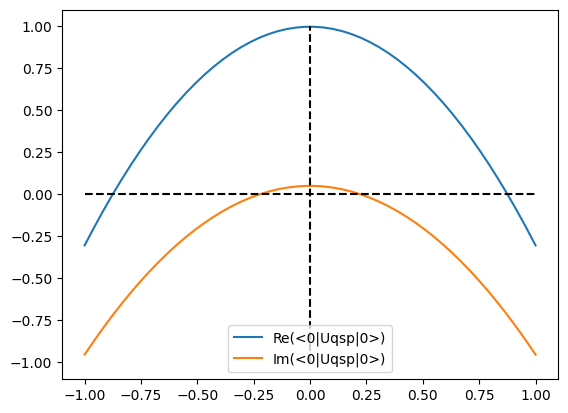

In [3]:
import matplotlib.pyplot as plt

degree = 2                                             # This is also the number of repetitions "d"
a_vals = np.linspace(-1, 1, 50)

phi_vals = (2*np.random.rand(degree + 1) - 1) * np.pi  # Sample "degree+1"-many phase angles from (-pi, pi)
# phi_vals = list(0 for _ in range(degree))            # Set all phase angles to 0 

poly_0_a = np.array([U_qsp(a, phi_vals)[0,0] for a in a_vals])

plt.plot(a_vals, np.real(poly_0_a), label="Re(<0|Uqsp|0>)")
plt.plot(a_vals, np.imag(poly_0_a), label="Im(<0|Uqsp|0>)")

plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

### Exercises: 
For each exercise, use the convention from the QSP theorem for the signal rotation operator.

- ***Exercise 1.1:*** What is the polynomial $P(a)$ constructed for a QSP circuit with phase angles $\vec{\phi} = (\frac{\pi}{4}, -\frac{\pi}{2}, 0)$?
- ***Exercise 1.2:*** Solve for the phase angles $(\vec{\phi} \in \mathbb{R}^3)$ that would generate a polynomial $P(a) = 1 - 2a^2$?
- ***Exercise 1.3:*** For both of the questions above, verify your solution by using the code above to plot the theoretical polynomial against the one generated using QSP.

## 2. Its Fun Fitting Functions!

As we learned in the previous section, the phase angles $\vec{\phi}$ fully determine the polynomial $P(a)$ that will be generated by a given QSP sequence. The next step is to find a way to compute the phase angles for a given polynomial so that we can construct it on our quantum computer, however, this is a non-trivial task. This topic has been heavily studied in literature (see [3] - [5]), with methods ranging from analytical formulas to hybrid optimization based workflows. In this section we will explore how to compute the phase angles for a target polynomial transformation by relying on gradient descent based optimization. 

This turns out to be a very powerful idea because it will ultimately allow us to approximate QSP transformations for functions which are *NOT* polynomials! 

### 2A) Learning Phase Angles on the Fly

The QSP theorem is a direct result of the matrix multiplication of certain key unitary matrices. This means that it is *differentiable*! One simple way to obtain the polynomial transformation we want is through optimization. The general idea is as follows: 

- Select a set of random initial phase angles $\vec{\phi}$ and a target polynomail (eg. $T(x) = x^5 - 3x^3 + x$),
- Prepare a quantum circuit which measures the expectation value $\langle 0| \hat{U}_{qsp}(a) |0 \rangle = P(a)$,
- Prepare a classical loss function, in this case we use Mean Squared Error (MSE),
- Run a standard optimization loop, where we update the phase angles based on the gradient of the loss function,
- Return the trained phase angles!

Here we rely on Pennylane to prepare and execute our quantum circuit `qsp_circ`, using the state vector simulator `defaul.qubit`. We use the builtin `qml.qsvt(a, phi_vals)` function to prepare the QSP operator.

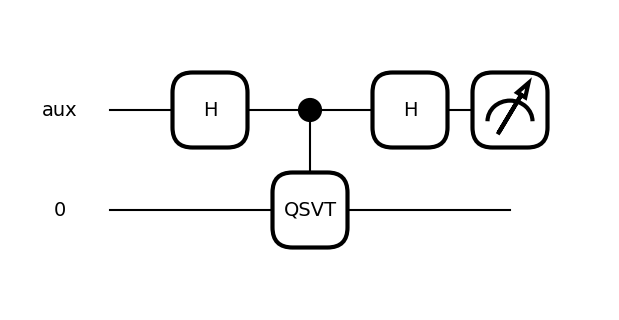

In [4]:
## Train a QSP circuit to fit a given polynomial function 

@qml.qnode(qml.device("default.qubit"))
def qsp_circ(a, phi_vals):  # We use the Hadamard test to extract Re(<0|U_qsp|>)
    qml.Hadamard("aux")
    qml.ctrl(qml.qsvt, control=("aux",), control_values=(1,))(a, phi_vals, wires=[0])
    qml.Hadamard("aux")
    return qml.expval(qml.Z("aux"))


qml.draw_mpl(qsp_circ)(0.5, [1, 2, 3])  # draw the quantum circuit! 


def target_func(x): 
    return x**5 - 3*x**3 + x  


def loss_func(phi_vals):  # Mean Squared Error (MSE) loss function for the Real value of P(a) 
    num_samples = 25
    
    loss = 0
    for a in np.linspace(-1, 1, num_samples):
        qsp_poly_a = qsp_circ(a, phi_vals)
        loss += (qsp_poly_a - target_func(a))**2

    return loss / num_samples 

In [5]:
# Optimization:
cost = 1
iteration = 0
opt = qml.AdagradOptimizer(0.1)

phi_vals = (2*np.random.rand(6) - 1) * np.pi/2
initial_phi = phi_vals

while cost > 1e-5:
    iteration += 1
    phi_vals, cost = opt.step_and_cost(loss_func, phi_vals)

    if iteration % 10 == 0 or iteration == 1:
        print(f"iter: {iteration}, cost: {cost}")

    if iteration > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

iter: 1, cost: 0.6534436355536181
iter: 10, cost: 0.014914791014946548
iter: 20, cost: 0.005438123003383516
iter: 30, cost: 0.0038412295717066116
iter: 40, cost: 0.0031688512692195614
iter: 50, cost: 0.002731651756486486
iter: 60, cost: 0.0023782362292458356
iter: 70, cost: 0.002063591919334682
iter: 80, cost: 0.0017741721779074892
iter: 90, cost: 0.0015079399097070463
iter: 100, cost: 0.0012669659969271121
Iteration limit reached!
Completed Optimization! (final cost: 0.0012443665729229738)


Now that we have successfully trained the phase angles, lets plot the resulting polynomial and compare it with the target polynomial:

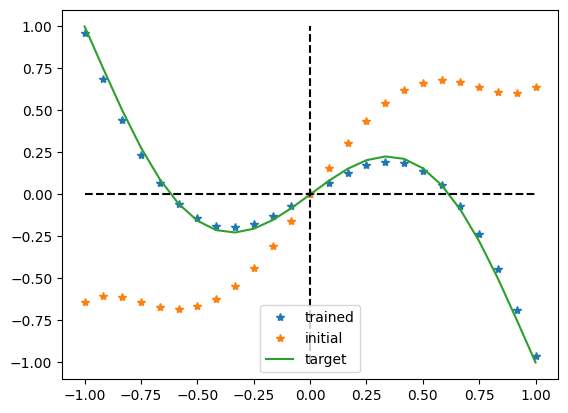

In [6]:
a_vals = np.linspace(-1, 1, 25)

trained_poly = [qml.matrix(qml.qsvt(a, phi_vals, wires=[0]))[0,0] for a in a_vals]
initial_poly = [qml.matrix(qml.qsvt(a, initial_phi, wires=[0]))[0,0] for a in a_vals]
targeted_poly = [target_func(a) for a in a_vals]

plt.plot(a_vals, np.real(trained_poly), "*", label="trained")
plt.plot(a_vals, np.real(initial_poly), "*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")

plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

We were successfully able to learn the phase angles for the target polynomial! 

### 2B) QSP as a Polynomial Function Approximator

Notice that all we did in the previous section was *"optimize some parameters according to some loss function"*. Nowhere did we enforce the restriction that our target must also be a polynomial, this begs the question:

**What happens if our target function isn't a polynomial?**

Since the QSP circuit can only generate polynomials $P(a)$, the optimization produces a polynomial approximation to our target function. If we can choose (or transform) our target function to have the same parity/symmetry as the QSP circuit, we can generate even more accurate polynomial approximations. In the next section, let's try and fit the Heaviside Step function using QSP!


In [7]:
def target_func(x): 
    return 1 if x>0 else -1  # Step function, notice it has odd parity

def loss_func(phi_vals):
    num_samples = 50  
    
    loss = 0
    for a in np.linspace(-1, 1, num_samples):
        qsp_poly_a = qsp_circ(a, phi_vals)
        loss += (qsp_poly_a - target_func(a))**2

    return loss / num_samples 


# Optimization:
cost = 1
iteration = 0
opt = qml.AdagradOptimizer(0.1)

phi_vals = np.random.rand(16)  # (d+1) has to be even since P(a) must be odd to match the parity 
initial_phi = phi_vals         #     of the step function.

while cost > 1e-5:
    iteration += 1
    phi_vals, cost = opt.step_and_cost(loss_func, phi_vals)

    if iteration % 10 == 0 or iteration == 1:
        print(f"iter: {iteration}, cost: {cost}")

    if iteration > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

iter: 1, cost: 0.18459082919235456
iter: 10, cost: 0.08633315849768045
iter: 20, cost: 0.08508985764307513
iter: 30, cost: 0.08418448297684451
iter: 40, cost: 0.08346049659816998
iter: 50, cost: 0.08286477599226139
iter: 60, cost: 0.08236682752289873
iter: 70, cost: 0.08194595358316356
iter: 80, cost: 0.08158696485784764
iter: 90, cost: 0.08127827354403719
iter: 100, cost: 0.0810108481401223
Iteration limit reached!
Completed Optimization! (final cost: 0.08098608669982857)


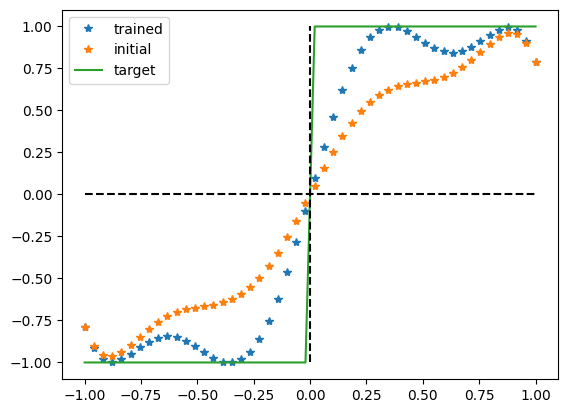

In [8]:
a_vals = np.linspace(-1, 1, 50)
trained_phase_angles = phi_vals

trained_poly = np.array([qml.matrix(qml.qsvt(a, trained_phase_angles, wires=[0]))[0,0] for a in a_vals])
initial_poly = np.array([qml.matrix(qml.qsvt(a, initial_phi, wires=[0]))[0,0] for a in a_vals])
targeted_poly = np.array([target_func(a) for a in a_vals])

plt.plot(a_vals, np.real(trained_poly), "*", label="trained")
plt.plot(a_vals, np.real(initial_poly), "*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")

plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

We were successfully able to train the phase angles to approximate the heaviside function with a polynomial of degree 15! Try experimenting with the degree of the QSP polynomial (i.e number of phase angles) to see how it affects the fit and optimization process. We will see that the phase angles computed from QSP can be directly used with QSVT.

### 2C) Recovering the Right Unitary


Another subtle, yet important point to address is that of the unitary we produce. As you may have noticed, our phase angle training protocol was fitting the real component $Re(P(a))$ of the polynomial generated from QSP. However, suppose we wanted to apply this polynomial transformation in the quantum circuit directly, the QSP unitary would not perform this transformation due to the non-zero imaginary component of $P(a)$. 

In general, the imaginary part of this transformation will not be zero. We need an operator which only applies the real component. Recall that we can express the real part of a complex number $z$ as: $$Re[z] = \frac{1}{2}(z + z^{*})$$ 

Similarly, for operators this is given by:

$$ \hat{U}_{real}(\vec{\phi}) = \frac{1}{2} \ ( \hat{U}_{qsp}(\vec{\phi}) + \hat{U}^{*}_{qsp}(\vec{\phi}) )$$

Where $A^*$ denotes the complex conjugate. We use the well known algorithm of "Linear Combinations of Unitaries" to get the real unitary transformation. We will not be explaining this algorithm in this lab, but you can reference [this demo](https://pennylane.ai/qml/demos/tutorial_lcu_blockencoding/) for more information. We obtain the complex conjugate $\hat{U}^{*}_{qsp}$ by setting $\vec{\phi} \rightarrow - \vec{\phi}$. 

By running the following circuit, if we measure the $|0\rangle$ state in the `"aux"` qubit, then we will have applied the the real unitary in the other register:

(<Figure size 700x300 with 1 Axes>, <Axes: >)

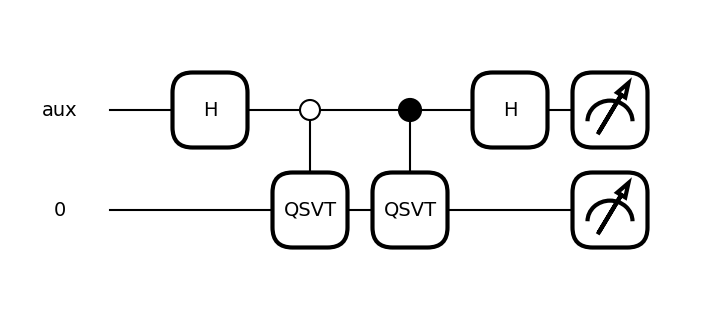

In [9]:
## Show how to recover the "real" unitary
dev = qml.device("default.qubit")

@qml.qnode(dev)
def real_u_circuit(a, phi):
    qml.Hadamard(wires="aux")

    qml.ctrl(qml.qsvt, control=("aux",), control_values=(0,))(a, phi, wires=[0])
    qml.ctrl(qml.qsvt, control=("aux",), control_values=(1,))(a, -1*phi, wires=[0])

    qml.Hadamard(wires="aux")
    return qml.state()

qml.draw_mpl(real_u_circuit)(0.5, np.array([0, 1, 2]))

### Exercises: 

- ***Exercise 2.1:*** Using the code above as a reference, can you find the phase angles to approximate $f(x) = sin(x)$?
- ***Exercise 2.2:*** Using the code above as a reference, can you find the phase angles to approximate $g(x) = cos(x)$?

***Bonus:*** Construct a circuit using the phase angles you computed above to perform the transformation below: (hint: use the method of LCUs) $$h(x) \approx e^{ix} = cos(x) + i*sin(x)$$

*Note:* The circuit you just created can be used to perform hamiltonian time evolution $e^{-iHt}$. This is another powerful application of QSP/QSVT.

## 3. Qubitized, Factorized and Generalized:

The first section covered the concept of QSP, where one can transform an entry in a single-qubit space through a polynomial function. In the previous section, we learned how to tune the free parameters of our circuit in order to generate a specific transformation. It turns out that these ideas can be lifted from the single-qubit case to the multi-qubit case, in which we are able to transform multiple entries of a matrix. This section will explore the ideas of Qubitization, and in doing so, allow us to lift all of our results from QSP to the case of transforming elements of a matrix $a \rightarrow A$.

Recall that quantum computers only support unitary transformations. If we have an input state $|\psi_{in}\rangle$, any gate we apply to it must be unitary $\hat{U}|\psi_{in}\rangle$. 

**How would we apply a non-unitary operation to a state using a quantum computer?**

The answer is *Block Encodings*! The idea is rather simple, we can embed the non-unitary transformation inside a larger operator which is unitary. There is rich theory behind this idea, we point readers to [this demo](https://pennylane.ai/qml/demos/tutorial_lcu_blockencoding/) for more information. Consider a non-unitary, square transformation $A: \mathbb{C}^{2^n} \rightarrow \mathbb{C}^{2^n}$ which can act on an $n$-qubit space (this is for simplicity and can be generalized to non-square matrices). We define a specific block encoding of $A$ as follows: 

$$\hat{U}(A) \coloneqq \begin{bmatrix} A & * \\ * & * \end{bmatrix}$$ 

Such that $\hat{U}(A): \mathbb{C}^{2^{m+n}} \rightarrow \mathbb{C}^{2^{m+n}}$ is a hermitian, unitary matrix defined on a larger $(m + n)$-qubit space. We can better understand how this operator works by considering its action on some particular states:

$$\hat{U}(A) |0^{m}\rangle|\psi\rangle = |0^{m}\rangle A|\psi\rangle + \alpha |\perp_{\psi}\rangle$$

Where $\alpha$ is some normalization factor. If we apply the block encoded unitary to a state which is in the all 0 state in the first $m$-qubits (i.e confined to the top-left block), then we get back $A|\psi\rangle$ in the remaining $n$-qubits plus another state which is completely orthogonal. Thus, if we measure the first $m$-qubits in the $|0^m\rangle$ state after we have applied the block-encoded operator, then we know that the state of the remaining $n$-qubits is proportional to $A|\psi\rangle$. Using this property of block-encodings, we will explore qubitization and how it relates to QSP. 

### 3A) Qubitization as an Elevator of QSP

Recall that we can express $A$ in terms of its Singular Value Decomposition (SVD) $A = \hat{W} \circ \Sigma \circ \hat{V}^{\dagger}$, or alternatively $\ A = \Sigma_{k} \sigma_{k} |w_{k}\rangle \langle v_{k}| \ \ $. 
Let's consider what happens when we apply the block-encoded matrix onto a singular vector of A, for simplicity and without loss of generality we can assume $m = 1$.

$$\begin{align*} \hat{U}(A) |0\rangle|v_{i}\rangle &= |0\rangle A|v_i\rangle \ \ + \ \ \alpha |\tilde{\perp}_{i}\rangle  \\ 
&= \sigma_i|0\rangle|w_i\rangle \ + \sqrt{1-\sigma^2_i}|\tilde{\perp}_{i}\rangle 
\end{align*}$$ 

Where $\alpha = \sqrt{1 - \sigma_{i}^2}$ to ensure the state is normalized. It turns out, that the action of $\hat{U}^{\dagger}(A)$ is similar, on the left singular vectors. This can be seen if we think about the conjugate-transpose of our block-encoding matrix, the top-left corner becomes $A^{\dagger}$.

$$\begin{align*} \hat{U}^{\dagger}(A) |0\rangle|w_{i}\rangle &= |0\rangle A^{\dagger}|w_i\rangle \ \ + \ \ \beta |\perp_{i}\rangle  \\ 
&= \sigma_i|0\rangle|v_i\rangle \ + \sqrt{1-\sigma^2_i}|\perp_{i}\rangle 
\end{align*}$$

Once again, the normalization factor $\beta = \sqrt{1 - \sigma_{i}^2}$ is the same as before. Let's notice what happens if we apply $U^{\dagger}(A)$ to both sides of the first equation: 

$$\begin{align*} \hat{U}^{\dagger}(A) \circ \hat{U}(A) |0\rangle|v_{i}\rangle &= \hat{U}^{\dagger}(A) (\sigma_i|0\rangle|w_i\rangle \ + \sqrt{1-\sigma^2_i}|\tilde{\perp}_{i}\rangle) \\
\mathbb{I} |0\rangle|v_{i}\rangle &= (\sigma^2_i|0\rangle|v_i\rangle \ + \sigma_i\sqrt{1-\sigma^2_i}|\perp_{i}\rangle) + \sqrt{1-\sigma^2_i}\hat{U}^{\dagger}(A)|\tilde{\perp}_{i}\rangle \ \ \ \ \ \ \ \ \ \ \ \  \text{Isolating for $|\tilde{\perp}_{i}\rangle$,} \\ 
\hat{U}^{\dagger}(A)|\tilde{\perp}_{i}\rangle &= \sqrt{1-\sigma^2_i}|0\rangle|v_i\rangle - \sigma_i|\perp_{i}\rangle
\end{align*}$$

Similarly, by applying $\hat{U}(A)$ to both sides of the second equation, we can show that $\hat{U}(A)|\perp_{i}\rangle = \sqrt{1-\sigma^2_i}|0\rangle|w_i\rangle -\sigma_i|\tilde{\perp}_{i}\rangle$. This may seem like pointless algebraic manipulation, but we have actually uncovered something powerful. We have identified two different spaces, $span\{|0\rangle|v_i\rangle, |\perp_{i}\rangle\}$ and $span\{|0\rangle|w_i\rangle, |\tilde{\perp}_{i}\rangle\}$. Furthermore, we can map freely between the two spaces using $\hat{U}(A)$ and $\hat{U}^{\dagger}(A)$. 

We can see this clearly by working through the following example: 

1. start in the state $|0\rangle|v_i\rangle$ and apply $\hat{U}(A)$ to move to the $span\{|0\rangle|w_i\rangle, |\tilde{\perp}_{i}\rangle\}$ space
2. perform a reflection across the state $|0\rangle|w_i\rangle$
3. apply $\hat{U}^{\dagger}(A)$ to move back to the $span\{|0\rangle|v_i\rangle, |\perp_{i}\rangle\}$ space

Mathematically, this works out as follows: (where $\tilde{\Pi} \coloneqq |0\rangle|w_i\rangle \langle 0|\langle w_i|$) 

$$\begin{align*}
 \hat{U}(A) |0\rangle|v_{i}\rangle &= \sigma_i|0\rangle|w_i\rangle \ + \sqrt{1-\sigma^2_i}|\tilde{\perp}_{i}\rangle  \ \ \ \ \ &\text{(1)} \\
 (2\tilde{\Pi} - \mathbb{I}) \circ \hat{U}(A) |0\rangle|v_{i}\rangle &= \sigma_i|0\rangle|w_i\rangle \ - \sqrt{1-\sigma^2_i}|\tilde{\perp}_{i}\rangle \ \ \ \ \ &\text{(2)} \\
  \hat{U}^{\dagger}(A) \circ (2\tilde{\Pi} - \mathbb{I}) \circ \hat{U}(A) |0\rangle|v_{i}\rangle &= \hat{U}^{\dagger}(A)(\sigma_i|0\rangle|w_i\rangle \ - \sqrt{1-\sigma^2_i}|\tilde{\perp}_{i}\rangle) \\ 
  &= \sigma_i^2|0\rangle|v_i\rangle \ + \sigma_i\sqrt{1-\sigma^2_i}|\perp_{i}\rangle - (1-\sigma^2_i)|0\rangle|v_i\rangle + \sigma_i\sqrt{1-\sigma^2_i}|\perp_{i}\rangle \\ 
  \hat{U}^{\dagger}(A) \circ (2\tilde{\Pi} - \mathbb{I}) \circ \hat{U}(A) |0\rangle|v_{i}\rangle &= (2\sigma_i^2 - 1)|0\rangle|v_i\rangle + 2\sigma_i\sqrt{1-\sigma^2_i}|\perp_{i}\rangle \ \ \ \ \ &\text{(3)}
\end{align*}$$

Note the coefficients after applying step 3. If you recall back from the section on QSP after applying these transformations, we see the Chebyshev polynomials are appearing again and we are performing rotations! The following figure highlights the transformations we just applied:

<br>

<div>
<img src="https://raw.githubusercontent.com/Jaybsoni/QSVT_Lab/17c65fa13b1bfffc22bc311dcf028e56ff521eb4/imgs/qubitized1.png" width="750"/>
<!-- <img src="imgs/qubitized1.png" width="750"/> -->
</div>

<br>

If we repeat the sequence $(2\Pi - \mathbb{I}) \circ \hat{U}^{\dagger}(A) \circ (2\tilde{\Pi} - \mathbb{I}) \circ \hat{U}(A)$, then we end up performing exactly the same types of rotations as we have seen with QSP. The truely surprising insight is that all of the analysis we did in this section so far, was general for any singular value $\sigma_i$ of $A$. This implies that we can perform these rotations to all of the singular values independantly at once! What we have shown, is that because the block encoding allows us to partition the space into these individual 2D subspaces (qubitized subspaces), we are able to perform QSP like rotations on each one individually.

In order to tune these rotations, we again introduce phase rotations. Here we generalize the idea of $Z$-rotations, to projector controlled rotations, where we rotate across the axis of the reflection operator.

$$ \tilde{\Pi}_{\phi} \coloneqq exp(i\phi\tilde{\Pi}), \ \ \ \Pi_{\phi} \coloneqq exp(i\phi\Pi)$$

Now we have all of the tools we need to understand the Quantum Singular Value Transformation theorem.

### 3B) Quantum Singular Value Transformation Theorem$^{[2]}$

Given a block encoding for the (generally non-square) matrix $A = \Sigma_{k} \sigma_{k} |w_{k}\rangle \langle v_{k}|$: 

 $$ \hat{U}(A) = \begin{bmatrix} A & *\\ * & * \end{bmatrix}$$ 
 
Additionally, given access to *projector controlled phase-shifts* $\hat{\Pi}_{\phi}$, $\hat{\tilde{\Pi}}_{\phi}$; The QSVT unitary is defined below
 
$$\begin{align*} \hat{U}_{qsvt}(\vec{\phi}, A) &\coloneqq \hat{\tilde{\Pi}}_{\phi_1}\hat{U}(A)\left[\prod_{k=1}^{(d-1)/2}\hat{\Pi}_{\phi_{2k}}\hat{U}^\dagger(A) \hat{\tilde{\Pi}}_{\phi_{2k+1}} \hat{U}(A)\right]\hat{\Pi}_{\phi_{d+1}} \ \ \ \ &\text{for $d$ odd,} \\
\hat{U}_{qsvt}(\vec{\phi}, A) &\coloneqq \left[\prod_{k=1}^{d/2}\hat{\Pi}_{\phi_{2k-1}}\hat{U}^\dagger(A) \hat{\tilde{\Pi}}_{\phi_{2k}} \hat{U}(A)\right]\hat{\Pi}_{\phi_{d+1}} &\text{for $d$ even.} \end{align*}$$

Such that, it can be expressed in matrix form as $\hat{U}_{qsvt}(\vec{\phi}, A) = \begin{bmatrix} P(A) & * \\ * & *\end{bmatrix}$. The polynomial transformation of A is defined in terms of its singular value decomposition, and is subject to all of the same constraints (degree, parity and normalization) as in the QSP case. 

$$ P(A) = \sum_k P(\sigma_k)|w_k\rangle \langle v_k| $$


### 3C) Code Example 

In this section, we will use everything we have learned to transform the singular values of a matrix $A$. In order to more easily visualize the transformation, we choose $A$ to be diagonal, with its entries increasing from $a \in [-1, 1]$, this way we can read of the singular values before and after the transformation $a \rightarrow P(a)$ directly!

In [10]:
eigvals = np.linspace(-1, 1, 16)
A = np.diag(eigvals)  # 16x16 diagonal matrix ==> 4 qubits to represent A 

print(np.round(A, 2)) 

[[-1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.   -0.87  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.   -0.73  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.6   0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.47  0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.33  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.2   0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.07  0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.07  0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.2   0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0

In order to apply the QSVT unitary, we again use the PennyLane function `qml.qsvt(A, wires)`. Here we use a 5 qubit system in order to block encode $A$. Since QSVT is a direct generalization of QSP, as long as we use the same convention for the block encoding as we have for the signal rotation operator, we can use the phase angles from QSP!

In this case, we use the phase angles we trained for the heaviside step function! We can verify that we have applied the correct transformation by simplying plotting the diagonal elements of the top-left corner of $\hat{U}_{qsvt}(A)$.

In [11]:
wire_order = list(range(5))  # 5-qubit system (4-qubits to specify A, 1 qubit to block encode) 

U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(A, trained_phase_angles, wires=wire_order)  
qsvt_A = np.real(np.diagonal(U_A))[:16]  # retrieve transformed eigenvalues

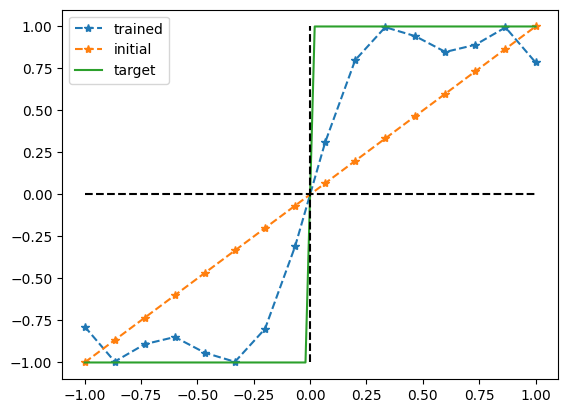

In [12]:
plt.plot(eigvals, qsvt_A, "--*", label="trained")
plt.plot(eigvals, np.diagonal(A), "--*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")


plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

We were successfully able to transform the singular values of $A$ according to the phase angles for the step function! Now, let's do this for a non-diagonal $A$. In order for us to extract the transformation and verify it, we need to find the singular value decomposition (SVD) for $A$. Instead of starting from a non-diagonal matrix and finding the SVD, we instead start with the diagonal matrix (from above), and *"scramble"* it, so that we know the SVD to begin with. 

In the code below, we build a random 16 by 16 unitary matrix which will scrable our diagonal matrix such that $A_{new} = \hat{V} \circ A \circ \hat{V}^{\dagger}$. In this framework, $\hat{V} \circ A \circ \hat{V}^{\dagger}$ is the SVD of $A_{new}$. Notice that $A_{new}$ is clearly not diagonal:

In [13]:
random_rotation_angles = (2*np.random.rand(3) - 1) * np.pi/2

random_unitary = qml.prod(
        qml.RX(random_rotation_angles[0], 0),
        qml.RY(random_rotation_angles[1], 1),
        qml.RZ(random_rotation_angles[2], 2),
        qml.Hadamard(4),
)

new_A = qml.matrix(random_unitary) @ A @ qml.matrix(qml.adjoint(random_unitary))
print(new_A)  # Clearly not diagonal 16 x 16 matrix 

[[-5.90098998e-01-1.20484572e-17j -6.66666667e-02-5.29877759e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.81943166e-01-6.89361942e-18j  8.00259926e-18+1.68944899e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   9.02105379e-18-4.64650494e-01j  6.59145749e-18-8.22897432e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.15305328e-17-3.98494134e-17j -4.59163890e-18-8.72284396e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-6.66666667e-02-5.29877759e-18j -5.90098998e-01-1.20484572e-17j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   8.00259926e-18+1.68944899e-18j -1.81943166e-01-6.89361942e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   6.59145749e-18-8.22897432e-18j  9.02105379e-18-4.64650494e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -4.59163890e-18-8.72284396e-18j  1.15305328e-17-3.98494134e-17j
   0.0000

We can pass the $A_{new}$ matrix directly into the QSVT algorithm just as was done above. The QSVT algorithm will perform the polynomial transformation to the singular values of $A_{new}$, thus to extract the results we need to *undo* this singular value decomposition $ \hat{U}_{qsvt}(A_{new}): A_{new} \rightarrow P(A_{new})$: 

$$\begin{align*} 
\hat{U}_{qsvt}(A_{new}) &\sim \hat{V} \circ P(A) \circ \hat{V}^{\dagger} \\ P(A) &\sim \hat{V}^{\dagger} \circ \hat{U}_{qsvt}(A_{new}) \circ \hat{V}
\end{align*}$$ 

In [14]:
U_new_A = qml.matrix(qml.qsvt, wire_order=wire_order)(new_A, trained_phase_angles, wires=wire_order)[:16, :16]  

unscrambled_U_new_A = qml.matrix(qml.adjoint(random_unitary)) @ U_new_A @ qml.matrix(random_unitary) 

qsvt_new_A = np.real(np.diagonal(unscrambled_U_new_A))  # retrieve transformed eigenvalues

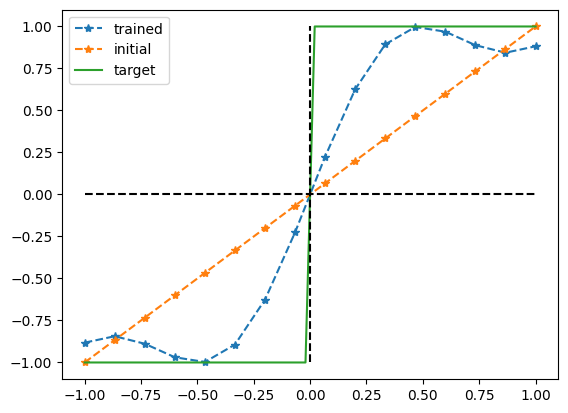

In [15]:
plt.plot(eigvals, qsvt_new_A, "--*", label="trained")
plt.plot(eigvals, np.diagonal(A), "--*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")


plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

We were successfully able to transform the singular values of $A_{new}$! Notice how remarkable this is, the QSVT algorithm allowed us to perform this transformation without having to compute the singular value decomposition at all.

## 4. Conclusions and Further Readings



In this lab we explored one of the most fundamental algorithmic building blocks in modern quantum computation, the Quantum Singular Value Transformation. Beginning with Quantum Signal Processing, we learned that repeated applications of a fixed signal rotation operator with interweaving phased rotations gives us tuneable polynomials. By manipulating the phase angles, we were able to control the types of polynomial transformations we generated. We then learned about qubitization, which allowed us to *"copy-paste"* the result of QSP to each 2D singular vector subspace of our target (block encoded) matrix $A$. Along the way, we used PennyLane to create quantum circuits, run experiments and test our knowledge in practice. I hope this lab has helped you build an intuative understanding for this algorithm! This leaves just one final question: 

**What comes next?**

Some immediate next steps would be to read "Grand Unification of Quantum Algorithms"$^{[2]}$ which explores how the framework of QSP and QSVT can be used to explain some of the most popular quantum algorithms (Hamiltonian Simulation, Unstructured Search, Matrix Inversion). For the problem of matrix inversion, I also recommend [this demo](https://pennylane.ai/qml/demos/tutorial_apply_qsvt/) which solves the problem using PennyLane! 

Since the initial publication of these ideas, there has been a growing interest in this algorithm. Here I list a few follow up works and directions for the keen readers. The two-axis rotations of QSP were further generalized to arbitrary axis rotations. This had some nice results for the complexity of the algorithm as well as the efficiency with which one could compute phase angles: 

- [Generalized Quantum Signal Processing](https://arxiv.org/abs/2308.01501)
- [Robust Angle Finding for Generalized Quantum Signal Processing](https://arxiv.org/abs/2402.03016)
- [Doubling the Efficiency of Hamiltonian Simulation via Generalized Quantum Signal Processing](https://arxiv.org/abs/2401.10321)

This idea was also lifted to QSVT:

- [Generalized Quantum Singular Value Transformation](https://arxiv.org/abs/2312.00723)

There was also work looking at dequantizing QSP:

- [Towards Dequantizing Quantum Signal Processing](https://arxiv.org/abs/2311.01533)

## 5. References:

- [1] András Gilyén, Yuan Su, Guang Hao Low, Nathan Wiebe, “[Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics](https://arxiv.org/abs/1806.01838)”, Proceedings of the 51st Annual ACM SIGACT Symposium on the Theory of Computing, 2019
- [2] John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang, “[Grand Unification of Quantum Algorithms](https://arxiv.org/pdf/2105.02859)”, PRX Quantum 2, 040203, 2021
- [3] Dong Y, Meng X, Whaley K, Lin L, “[Efficient phase-factor evaluation in quantum signal processing](https://arxiv.org/pdf/2002.11649)”, Phys. Rev. A 103, 042419 –, 2021
- [4] Chao R, Ding D, Gilyen A, Huang C, Szegedy M, “[Finding Angles for Quantum Signal Processing with Machine Precision](https://arxiv.org/abs/2003.02831)”, arXiv, 2003.02831, 2020
- [5] Haah J, “[Product decomposition of periodic functions in quantum signal processing](https://quantum-journal.org/papers/q-2019-10-07-190/)”, Quantum 3, 190, 2019

In [16]:
et = time.time()
print("Execution time for notebook: ",et-st, " seconds")

Execution time for notebook:  195.83499121665955  seconds
